In [1]:
!pip install python-doctr
!pip install "python-doctr[tf]"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.3/908.3 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/

In [2]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.6/780.6 kB 5.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os.path

import  torch
from ultralytics import YOLO
import sys

import pandas as pd
import numpy as np
from PIL import Image
import os

from doctr.models import ocr_predictor
from doctr.io import DocumentFile

In [ ]:
print(torch.version.cuda)
print(torch.__version__)
print(sys.version)

12.1
2.3.0+cu121
3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [ ]:
#Verificar si CUDA esta disponible
if torch.cuda.is_available():
    print('CUDA is available')
    print('Numero de GPUs disponible: ', torch.cuda.device_count())
    print('Nombre de la GPU: ', torch.cuda.get_device_name(0))
else:
    print('CUDA is not available')


CUDA is not available


# Parse de una Cedula de Identidad mediante Yolo V8 y DocTR
El presente Jupyter Notebook tiene como objetivo delinear la metodología empleada para el parseo de una cédula de identidad ecuatoriana hacia datos estructurados mediante el uso de una Red Neuronal Convolucional (CNN) desarrollada bajo el algoritmo YOLOv8.

Para el proceso de Reconocimiento Óptico de Caracteres (OCR), se utiliza la biblioteca DocTR, seleccionada por su superior rendimiento en comparación con otras bibliotecas OCR como Tesseract. Esta elección se fundamenta en la integración de DocTR con diversas técnicas de aprendizaje profundo (deep learning) durante el proceso de entrenaminto de sus modelos de deteccion ed caracteres, lo cual permite una estimación más precisa del texto presente en las imágenes.

In [ ]:
# Se carga los modelos previamente entrenado mediante el algortimo de YOLO
model_recognize_CI = YOLO('/content/drive/MyDrive/DNI_Proyect/Models_Documents_CI/CI_detection/best.pt')
model_recognize_fields = YOLO('/content/drive/MyDrive/DNI_Proyect/Models_Documents_CI/Region_Detection/best.pt')

## Extraccion de las regiones de Interes donde se encuentre una cedula de identidad
Como primer paso se ejecuta el modelo model_recognize_DNI, el cual tiene como finalidad identificar si dentro del archivo enviado existe un cedula de identidad(Ya sea la parte frontal o e reverso) En caso de detectarse una cedula de identidad se extrae la imagen presente dentro del Boung Box

In [ ]:
# Como primer paso se ejecuta el modelo model_recognize_DNI, el cual tiene como finalidad identificar si dentro del archivo enviado existe un cedula de identidad(Ya sea la parte frontal o e reverso) En caso de detectarse una cedula de identidad se extrae la imagen presente dentro del Boung Box

path_image = '/content/drive/MyDrive/DNI_Proyect/Random_Tests/162_0.png'
region_ci = model_recognize_CI(path_image)

# Process results list
for result in region_ci:
    region_ci_boxes = result.boxes  # Boxes object for bounding box outputs
    region_ci_masks = result.masks  # Masks object for segmentation masks outputs
    region_ci_keypoints = result.keypoints  # Keypoints object for pose outputs
    region_ci_probs = result.probs  # Probs object for classification outputs
    region_ci_obb = result.obb  # Oriented boxes object for OBB outputs
    #result.show()  # display to screen
    path_save = os.path.join('/content/drive/MyDrive/DNI_Proyect/Saves_images', 'result_CI_identify.jpg')
    result.save(filename=path_save)  # save to disk



image 1/1 /content/drive/MyDrive/DNI_Proyect/Random_Tests/162_0.png: 640x480 2 CI_Frontals, 1 CI_Reverso, 339.3ms
Speed: 19.2ms preprocess, 339.3ms inference, 31.3ms postprocess per image at shape (1, 3, 640, 480)


In [ ]:
# Se grafica la imagen original que a la cual se le realizara todo el procedimiento
# Cargar la imagen
image_original = Image.open(path_image)
width, height = image_original.size
display(image_original)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Creamos un Datframe en el cual vamos a almacenar toda la informacion sobre la extraccion de las regiones en la cual se encuentran as cedulas de identidad
# Incluyendo la confianza de la prediccion, la clase, las coordenadas xyxyn y xywhn
df_regions_ci = pd.DataFrame(columns=['confidence', 'clase', 'coordenate xyxyn', 'coordenate xywhn'])
coordante_xyxyn = []
coordante_xywhn = []
for index, confidence in enumerate(region_ci_boxes.conf):
    if confidence.cpu().item() > 0.80:
        new_register = {
            'confidence': region_ci_boxes.conf[index].cpu().item(),
            'clase': region_ci_boxes.cls[index].cpu().item(),
            'coordenate xyxyn': region_ci_boxes.xyxy[index].cpu().numpy(),
            'coordenate xywhn': region_ci_boxes.xywhn[index].cpu().numpy(),
        }
        df_regions_ci.loc[len(df_regions_ci)] = new_register


In [ ]:
df_regions_ci

,confidence,clase,coordenate xyxyn,coordenate xywhn
0,0.933335,1.0,"[828.9532, 798.01953, 1804.621, 1415.4131]","[0.53790325, 0.3285975, 0.3985571, 0.18331163]"
1,0.916703,0.0,"[845.02185, 113.16342, 1815.849, 732.90125]","[0.54347855, 0.12560342, 0.3965797, 0.18400766]"


In [ ]:
# Se procede a recortarse las regiones en las cuales se detecto que existe una cedula de identidad
cropped_images = []
side_list = []
for index, row in df_regions_ci.iterrows():
    crop_area = tuple(row['coordenate xyxyn'])
    cropped_image = image_original.crop(crop_area)
    cropped_images.append(cropped_image)
    side_list.append(df_regions_ci.loc[index, 'clase'])

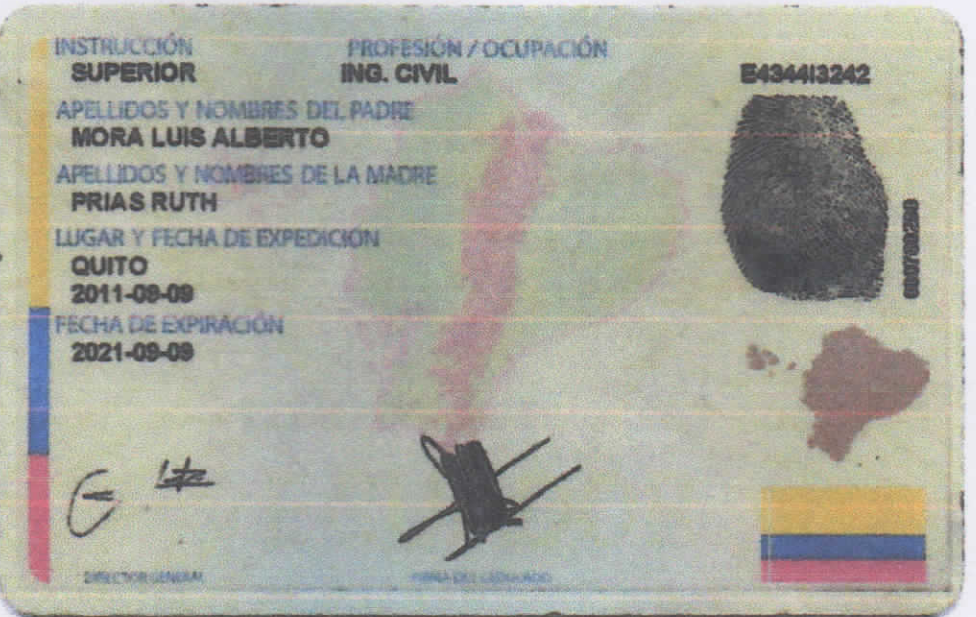

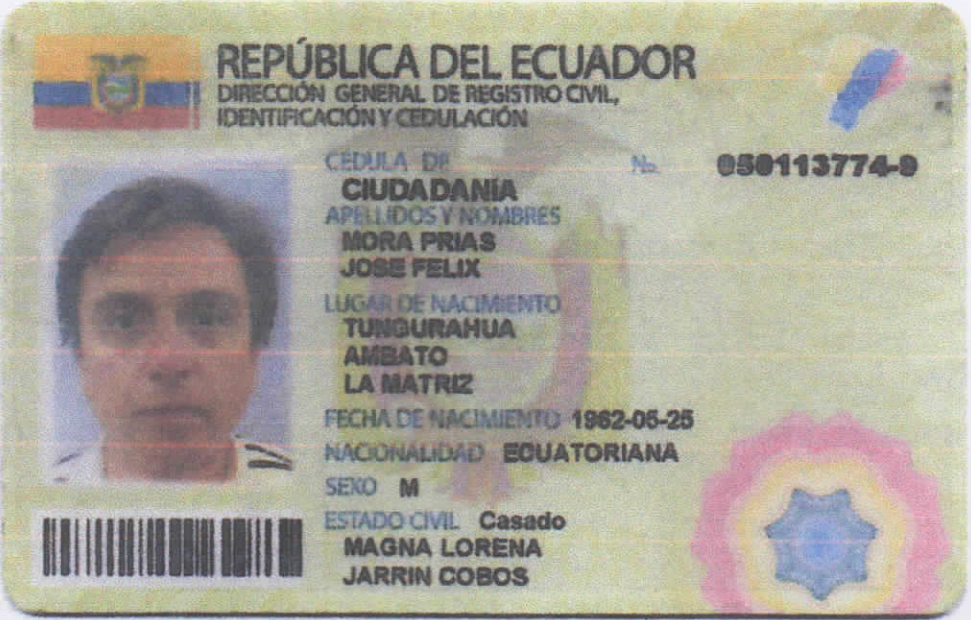

In [ ]:
# Se indican las regiones de interes donde se encuentra la cedula de identidad. En este caso no es necesario tener una precision alta en los Bounding Boxex sino es mas importante que el documento dentro de dicha zona de interes corresponde a una cedula de identidad. Esto con la finalidad de posteriormente escalar el sistema a otros tipos de documentos
for img in cropped_images:
    # Convertir la imagen de NumPy a objeto PIL Image
    # Mostrar la imagen en el cuaderno
    display(img)

## Extraccion de los campos de la cedula de identidad
Una vez contamos con las regiones de interes donde se encuentra la cedula de identidad, se procede a utilizar el modelo de deteccion de regiones de Interes de los campos de la cedula de identidad. Para ello se ejecuta el modelo model_recognize_fields, el cual tiene como finalidad identificar los campos presentes en la cedula de identidad y extraer la informacion presente en cada uno de ellos.

In [ ]:
region_fields_images = []
count = 0
for img in cropped_images:
    count += 1
    fields_CI = model_recognize_fields(img)
    region_fields_images.append(fields_CI)
    for result in fields_CI:
        fields_CI_boxes = result.boxes  # Boxes object for bounding box outputs
        fields_CI_masks = result.masks  # Masks object for segmentation masks outputs
        fields_CI_keypoints = result.keypoints  # Keypoints object for pose outputs
        fields_CI_probs = result.probs  # Probs object for classification outputs
        fields_CI_obb = result.obb  # Oriented boxes object for OBB outputs
        fields_side = side_list[count-1]
        #result.show()  # display to screen
        path_save = os.path.join('/content/drive/MyDrive/DNI_Proyect/Saves_images', 'result_Fields' + str(count) + '.jpg')
        result.save(filename=path_save)  # save to disk


0: 416x640 1 Instruccion, 1 Profesion, 1 Nombres Padre, 1 Nombres Madre, 1 Lugar Expedicion, 1 Fecha Expedicion, 1 Fecha Expiracion, 1 Codigo Dactilar, 1 Huella, 254.7ms
Speed: 4.0ms preprocess, 254.7ms inference, 1.9ms postprocess per image at shape (1, 3, 416, 640)

0: 416x640 1 Foto, 1 Condicion, 1 ID, 1 Apellidos, 1 Nombres, 2 Lugar Nacimientos, 1 Fecha Nacimiento, 1 Nacionalidad, 1 Sexo, 1 Estado Civil, 217.4ms
Speed: 3.6ms preprocess, 217.4ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


In [ ]:
# Creamos un Datframe en el cual vamos a almacenar toda la informacion sobre la extraccion de las regiones en la cual se encuentran as cedulas de identidad
# Incluyendo la confianza de la prediccion, la clase, las coordenadas xyxyn y xywhn
df_fields_ci = pd.DataFrame(columns=['confidence', 'clase', 'coordenate xyxy', 'coordenate xyxyn', 'coordenate xywhn', 'name_class', 'side'])
coordante_xyxyn = []
coordante_xywhn = []
clases_names = region_fields_images[0][0].names
cont = 0;
for img_predict_fields in region_fields_images:
    print(side_list[cont])

    for index, confidence in enumerate(img_predict_fields[0].boxes.conf):
        if confidence.cpu().item() > 0.50:
            new_register = {
                'side': side_list[cont-1],
                'confidence': img_predict_fields[0].boxes.conf[index].cpu().item(),
                'clase': img_predict_fields[0].boxes.cls[index].cpu().item(),
                'coordenate xyxy': img_predict_fields[0].boxes.xyxy[index].cpu().numpy(),
                'coordenate xyxyn': img_predict_fields[0].boxes.xyxyn[index].cpu().numpy(),
                'coordenate xywhn': img_predict_fields[0].boxes.xywhn[index].cpu().numpy(),
                'name_class': clases_names[int(img_predict_fields[0].boxes.cls[index].cpu().item())],
            }
            df_fields_ci.loc[len(df_fields_ci)] = new_register
    cont += 1

1.0
0.0


In [ ]:
df_fields_ci

,confidence,clase,coordenate xyxy,coordenate xyxyn,coordenate xywhn,name_class,side
0,0.978193,18.0,"[717.88763, 91.60706, 891.82324, 297.6439]","[0.7355406, 0.14847174, 0.91375333, 0.482405]","[0.824647, 0.31543836, 0.17821272, 0.3339333]",Huella,0.0
1,0.944473,10.0,"[69.70595, 58.65536, 199.7488, 84.462456]","[0.07142003, 0.095065415, 0.20466065, 0.13689215]","[0.13804033, 0.11597878, 0.13324063, 0.041826732]",Instruccion,0.0
2,0.942443,11.0,"[337.72092, 59.31184, 460.55508, 87.477776]","[0.34602553, 0.0961294, 0.4718802, 0.14177921]","[0.40895286, 0.1189543, 0.12585469, 0.045649815]",Profesion,0.0
3,0.901621,17.0,"[738.3387, 59.66398, 873.4929, 85.043785]","[0.7564946, 0.096700124, 0.89497226, 0.13783434]","[0.82573336, 0.11726723, 0.1384777, 0.04113421]",Codigo Dactilar,0.0
4,0.838410,16.0,"[69.62276, 339.15717, 196.0639, 365.00946]","[0.071334794, 0.54968745, 0.20088515, 0.5915875]","[0.13610996, 0.57063746, 0.12955035, 0.04189999]",Fecha Expiracion,0.0
5,0.796621,12.0,"[68.495285, 122.40359, 327.80515, 149.07602]","[0.0701796, 0.19838507, 0.3358659, 0.2416143]","[0.20302275, 0.21999969, 0.26568633, 0.043229226]",Nombres Padre,0.0
6,0.781333,14.0,"[71.55302, 253.50444, 150.40675, 276.58246]","[0.07331251, 0.4108662, 0.15410528, 0.44826978]","[0.113708906, 0.429568, 0.08079276, 0.037403595]",Lugar Expedicion,0.0
7,0.746880,13.0,"[69.87693, 188.03867, 220.58817, 213.89229]","[0.071595214, 0.30476284, 0.22601247, 0.34666497]","[0.14880383, 0.3257139, 0.15441726, 0.041902144]",Nombres Madre,0.0
8,0.646564,15.0,"[70.694275, 280.05447, 195.50441, 305.85846]","[0.07243266, 0.45389703, 0.2003119, 0.49571875]","[0.13637227, 0.47480792, 0.12787923, 0.041821696]",Fecha Expedicion,0.0
9,0.967915,0.0,"[44.447697, 161.47112, 292.24576, 482.2752]","[0.045775175, 0.26043728, 0.300974, 0.77786326]","[0.1733746, 0.51915026, 0.25519884, 0.51742595]",Foto,1.0


In [ ]:
img_fields_1 = Image.open('/content/drive/MyDrive/DNI_Proyect/Saves_images/result_Fields1.jpg')
img_fields_2 = Image.open('/content/drive/MyDrive/DNI_Proyect/Saves_images/result_Fields2.jpg')
display(img_fields_1)
display(img_fields_2)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Se aplica un metodo de OCR mediate la utilziacion del la libreria Doctr para obtener la informacion de la imagen y
# mediante el modelo entrenado con la arquitectura de deteccion de cajas de texto DB_Resnet50 y la arquitectura de
# reconocimiento de texto CRNN_VGG16_BN
model_OCR = ocr_predictor(det_arch='db_resnet50', reco_arch='crnn_vgg16_bn', pretrained=True)
single_img_doc_1 = DocumentFile.from_images('/content/drive/MyDrive/DNI_Proyect/Saves_images/result_Fields1.jpg')
single_img_doc_2 = DocumentFile.from_images('/content/drive/MyDrive/DNI_Proyect/Saves_images/result_Fields2.jpg')

# Extracciuon del texto mediante un proceso de OCR

Mediante la libreria de docTR se extrae la informacion de cada una de las imagenes recortadas para posteriormente realizar un proceso de match en funcion del aera que se superponen entre los bounding boxes detectadas por del OCR y el proceso de identificacion de las areas de interes

In [ ]:
result_ocr_img_1 = model_OCR(single_img_doc_1).export()
result_ocr_img_2 = model_OCR(single_img_doc_2).export()

In [ ]:
def get_results_OCR_to_df(result_ocr_img, side):
  # Se extraen las palabras-lineas-bloques-coordenadas del OCR en un df de pandas
  results = []
  count_block = 0
  count_line = 0
  count_word = 0
  for bloque in result_ocr_img['pages'][0]['blocks']:
    for line in bloque['lines']:
      for word in line['words']:
        coordendas = word['geometry']
        del word['geometry']
        word['lower_limit'] = coordendas[0]
        word['higher_limit'] = coordendas[1]
        word['word'] = count_word
        word['line'] = count_line
        word['block'] = count_block
        count_word += 1
        results.append(word)
      count_word = 0
      count_line += 1
    count_line = 0
    count_block += 1

  # Se crea un Dataframe con los datos Obtenidos de la lista del OCR
  df_results_OCR = pd.DataFrame(results)
  df_results_OCR['side_OCR'] = side
  df_results_OCR.rename(columns={'confidence': 'confidence_OCR'}, inplace=True)
  return df_results_OCR

In [ ]:
df_results = pd.concat([get_results_OCR_to_df(result_ocr_img_1, 0), get_results_OCR_to_df(result_ocr_img_2, 1)], ignore_index=True, axis=0)
df_results

,value,confidence_OCR,lower_limit,higher_limit,word,line,block,side_OCR
0,Instruccion,0.235375,"(0.0556640625, 0.06128444084278767)","(0.1884765625, 0.09990376823338737)",0,0,0,0
1,0.94,0.999572,"(0.1953125, 0.059739667747163716)","(0.2509765625, 0.09990376823338737)",1,0,0,0
2,SUPERIOR,0.965560,"(0.068359375, 0.09217990275526744)","(0.2080078125, 0.14161264181523503)",0,1,0,0
3,Profesion,0.998659,"(0.3427734375, 0.06128444084278767)","(0.447265625, 0.10144854132901132)",0,0,1,0
4,0.94CUPACION,0.509653,"(0.4541015625, 0.05201580226904379)","(0.625, 0.10144854132901132)",1,0,1,0
...,...,...,...,...,...,...,...,...
86,Casado,0.942285,"(0.4873046875, 0.8181199596774194)","(0.58984375, 0.8640026461693548)",1,0,12,1
87,MAGNA,0.997148,"(0.3525390625, 0.8624732232862904)","(0.447265625, 0.9022382182459677)",0,1,12,1
88,LORENA,0.998471,"(0.453125, 0.8640026461693548)","(0.5595703125, 0.9037676411290323)",1,1,12,1
89,JARRIN,0.999428,"(0.3505859375, 0.9098853326612903)","(0.4453125, 0.9481209047379032)",0,2,12,1


In [ ]:
def bounding_boxes_overlap_percentage(box1_lower,  box1_upper, box2_lower, box2_upper):
    """
    Calcula el porcentaje de área superpuesta entre dos bounding boxes.

    Parameters:
    box1, box2: Cada uno debe ser una tupla o lista de cuatro elementos (x_min, y_min, x_max, y_max)

    Returns:
    El porcentaje de área superpuesta con respecto al área total de las dos bounding boxes.
    """
    # Descomponer las coordenadas de las bounding boxes
    x1_min, y1_min = box1_lower
    x2_min, y2_min = box2_lower
    x1_max, y1_max = box1_upper
    x2_max, y2_max = box2_upper

    # Calcular las coordenadas de la bounding box de intersección
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # Calcular el área de la intersección
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    inter_area = inter_width * inter_height

    # Calcular las áreas de las bounding boxes individuales
    area_box1 = (x1_max - x1_min) * (y1_max - y1_min)
    area_box2 = (x2_max - x2_min) * (y2_max - y2_min)

    # Calcular el área total de las dos bounding boxes
    total_area = area_box1 + area_box2 - inter_area

    # Calcular el porcentaje de área superpuesta
    overlap_percentage = (inter_area / total_area) * 100 if total_area > 0 else 0

    # Calcular el porcentaje del área de la bounding box 1 que está dentro de la bounding box 2
    box1_in_box2_percentage = (inter_area / area_box1) * 100 if area_box1 > 0 else 0

    #print(box1_in_box2_percentage)
    return box1_in_box2_percentage

In [ ]:
list_OCR = []
list_model = []
# Seextrae el texto dentro de las bounding boxes en aquellas que exista una area de
# de conccordancia mayor al 60%
for index, row_OCR in df_results.iterrows():
  for index, row_model in df_fields_ci.iterrows():
    #print(row_OCR['lower_limit'])
    overlap_percetage = bounding_boxes_overlap_percentage(row_OCR['lower_limit'], row_OCR['higher_limit'], (row_model['coordenate xyxyn'][0], row_model['coordenate xyxyn'][1]), (row_model['coordenate xyxyn'][2], row_model['coordenate xyxyn'][3]))
    if overlap_percetage > 20 and row_model['side'] == row_OCR['side_OCR']:
      list_OCR.append(row_OCR[['value', 'confidence_OCR', 'word', 'line', 'block','side_OCR']].values.tolist())
      list_model.append(row_model[['confidence', 'clase', 'name_class', 'side']].values.tolist())



In [ ]:
# Se cpncatenan los valores detectado por el proceso de OCR y el proceso
# deteccion de regiones de inetres de la CNN para integrarlos a un unico df
df_final_result = 0
concatenated_lists = []
for sublist1, sublist2 in zip(list_OCR, list_model):
  concatenated_lists.append(sublist1 + sublist2)

columns_name1 = df_results[['value', 'confidence_OCR', 'word', 'line', 'block', 'side_OCR']].columns
columns_name2 = df_fields_ci[['confidence', 'clase', 'name_class', 'side']].columns

columns_name_final = columns_name1.values.tolist() + columns_name2.values.tolist()
df_final_result = pd.DataFrame(concatenated_lists, columns=columns_name_final)



,value,confidence_OCR,word,line,block,side_OCR,confidence,clase,name_class,side
16,AApellidos,0.884560,0,2,3,1,0.957808,3.0,Apellidos,1.0
18,0.951,0.347573,1,3,3,1,0.957808,3.0,Apellidos,1.0
17,Nombres,0.981176,0,3,3,1,0.957808,3.0,Apellidos,1.0
1,Codigo,0.998745,0,0,2,0,0.901621,17.0,Codigo Dactilar,0.0
2,Huella,0.974519,0,1,2,0,0.901621,17.0,Codigo Dactilar,0.0
3,5,0.498077,1,1,2,0,0.901621,17.0,Codigo Dactilar,0.0
4,098742,0.071380,2,1,2,0,0.901621,17.0,Codigo Dactilar,0.0
15,CIUDADANIA,0.854788,0,1,3,1,0.945673,1.0,Condicion,1.0
33,Casado,0.942285,1,0,12,1,0.905366,9.0,Estado Civil,1.0
13,2011-08-09,0.929232,0,1,8,0,0.646564,15.0,Fecha Expedicion,0.0


Se Guarda en un dataframe todos los valores los cuales hicieron match entre los bounding boxes del OCR y del modelo presente.
Dicho Dataframe representa toda la informacion extraida de las cedulas de identidad
Esto posteriomente a realizar un proceso de filtrado de las lectura del OCR

In [ ]:
df_final_result

,Unnamed: 0,value,confidence_OCR,word,line,block,side_OCR,confidence,clase,name_class,side
0,0,SUPERIOR,0.965560,0,1,0,0,0.944473,10,Instruccion,0
1,1,E4344I3242,0.998745,0,0,2,0,0.901621,17,Codigo Dactilar,0
2,5,ING.,0.985777,0,0,3,0,0.942443,11,Profesion,0
3,6,CIVIL,0.924355,1,0,3,0,0.942443,11,Profesion,0
4,7,MORALUISALBErTO,0.361848,0,1,4,0,0.796621,12,Nombres Padre,0
5,8,PRIAS,0.998888,0,0,6,0,0.746880,13,Nombres Madre,0
6,9,RUTH,0.948223,1,0,6,0,0.746880,13,Nombres Madre,0
7,10,Quito,0.997183,0,0,7,0,0.781333,14,Lugar Expedicion,0
8,13,2011-08-09 00:00:00,0.929232,0,1,8,0,0.646564,15,Fecha Expedicion,0
9,14,2021-09-09 00:00:00,0.292456,0,1,10,0,0.838410,16,Fecha Expiracion,0
